## Predicting Housing Prices with Linear Regression

Now I am going to work with a dataset which has 10 types of metrics such as the population, median income, median housing price, and so on for each block group in California to predict the housing prices.

In [1]:
import pandas as pd
import numpy as np

# load the california housing dataset
df = pd.read_csv('california_housing.csv')

In [2]:
print(df)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                  41          880           129.0   
1        -122.22     37.86                  21         7099          1106.0   
2        -122.24     37.85                  52         1467           190.0   
3        -122.25     37.85                  52         1274           235.0   
4        -122.25     37.85                  52         1627           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                  25         1665           374.0   
20636    -121.21     39.49                  18          697           150.0   
20637    -121.22     39.43                  17         2254           485.0   
20638    -121.32     39.43                  18         1860           409.0   
20639    -121.24     39.37                  16         2785           616.0   

       population  households  median_income ocean_

Here I only consider houses less than one hour from the Ocean or inland.

In [3]:
# Focus on Near Bays and Inlands only 
df = df[df['ocean_proximity'].str.contains('<1H OCEAN') | df['ocean_proximity'].str.contains('INLAND')]

# Change values in the ocean_proximity into binary
df['ocean_proximity'] = df['ocean_proximity'].map({'<1H OCEAN': 1, 'INLAND': 0})

In [4]:
# Drop missing values
df = df.dropna()

### Using Correlation Matrices to Check Multicollinearity among predictors


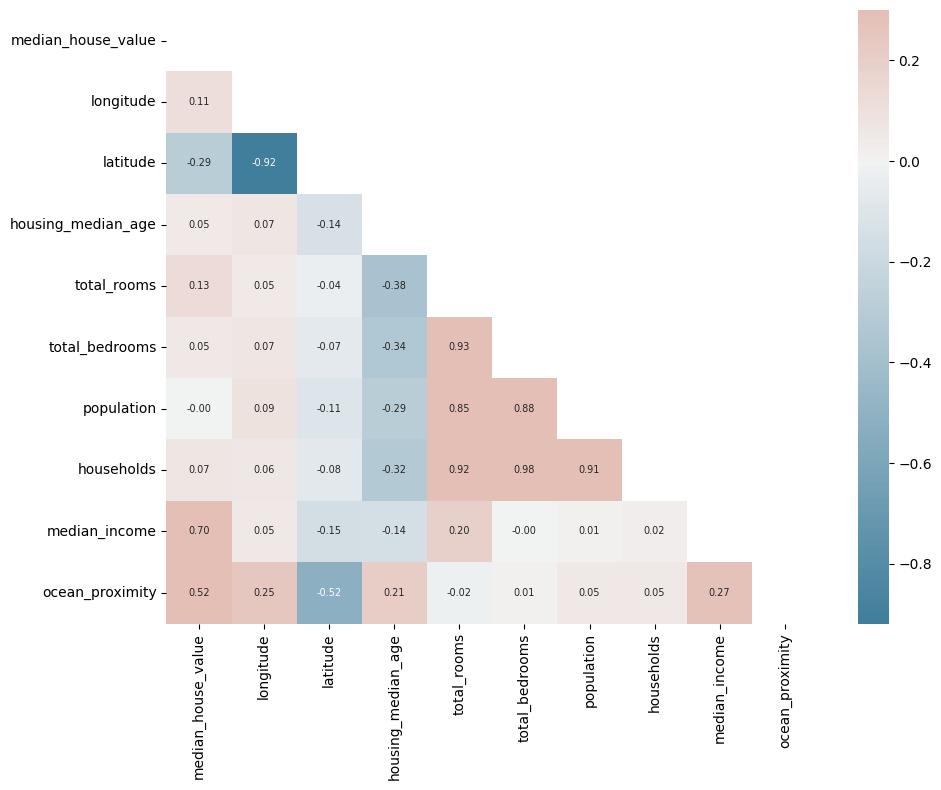

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set housing price as the first column in df to create a combined DataFrame YX
YX = df[['median_house_value'] + [c for c in df.columns if c != 'median_house_value']]

# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

**Interpret**

In order to improve our model, we decrease predictors with high multicollinearity.

### Now we estimate the `California Housing` regression

In [6]:
import pandas as pd
import statsmodels.api as sm


# Specify the columns to be included in X. Ensure all are numeric
X = df[['housing_median_age','total_rooms','median_income','ocean_proximity']]
y = df['median_house_value']

# Add a constant to the features to account for the intercept in the model
X_with_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     6297.
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:20:02   Log-Likelihood:            -1.9466e+05
No. Observations:               15530   AIC:                         3.893e+05
Df Residuals:                   15525   BIC:                         3.894e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.583e+04   2107

### Inference by `Approximate Posterior` Simulations


Simulate 1000 values from the approximate posterior distribution of each of these coefficients.

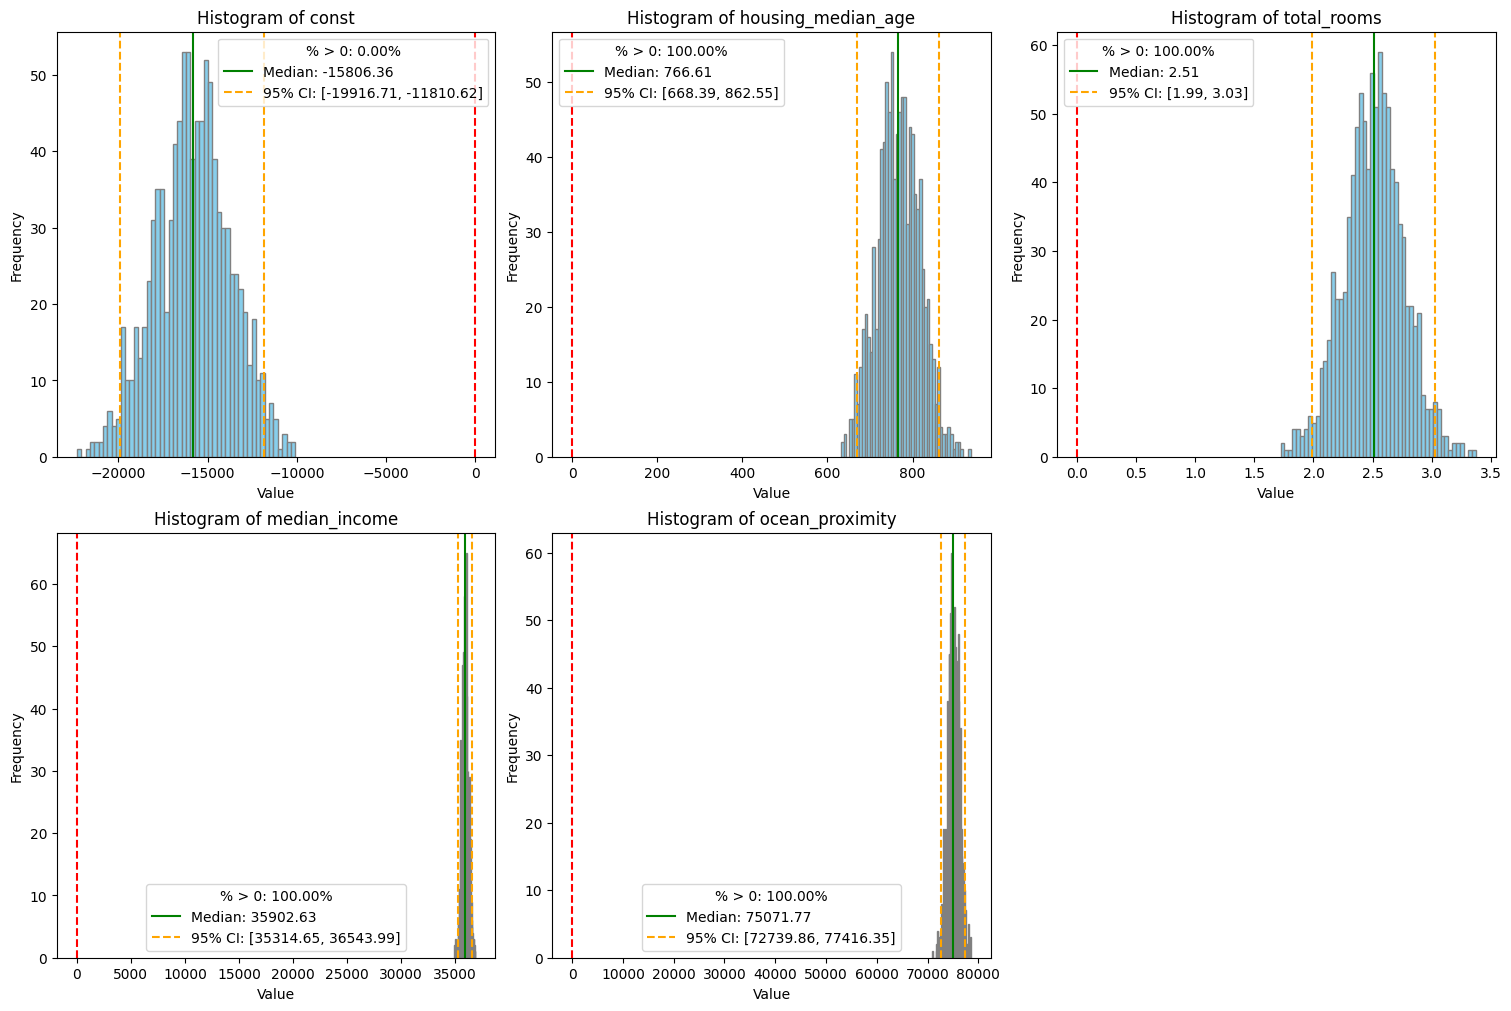

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate values from empirical posterior distribution of model coefficients
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), 1000)

# Extract parameter names dynamically
parameter_names = model.params.index.tolist()
n_params = len(parameter_names)

# Determine rows and columns dynamically
n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()

### Generate Predicted Values and Estimate Statistics

In [8]:
import statsmodels.api as sm
import numpy as np

# Design matrix with intercept
X_new_with_const = sm.add_constant(X)

# Predict new values (deterministic fitted values)
new_predictions = model.predict(X_new_with_const)

# Simulate fitted values by multiplying sampled betas with design matrix
fitted_value_samples = X_new_with_const @ coeff_samples.T

# Calculate median and prediction intervals for fitted values
monte_carlo_medians = np.median(fitted_value_samples, axis=1)
prediction_intervals = np.percentile(fitted_value_samples, [2.5, 97.5], axis=1)

# Output results
print("Median of fitted values (per observation):", monte_carlo_medians)
print("95% Prediction intervals:", prediction_intervals)

Median of fitted values (per observation): [304569.66804397 242194.32897634 251992.90804282 ...  63976.52703616
  69757.41745113  89270.1777517 ]
95% Prediction intervals: [[302622.56255678 239852.37716394 250281.88768085 ...  61811.03528597
   67618.92688577  87236.61407511]
 [306662.58674304 244575.66858469 253699.36417765 ...  66003.89343991
   71701.27280925  91102.78686553]]


### Plot Observed vs. Predicted Values with Prediction Intervals

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)
coverage = np.mean((y >= prediction_intervals[0, :]) & (y <= prediction_intervals[1, :]))

# Calculate min and max for plot limits directly
min_val = min(y.min(), monte_carlo_medians.min())
max_val = max(y.max(), monte_carlo_medians.max())

In [10]:
rmse

67225.42752342194

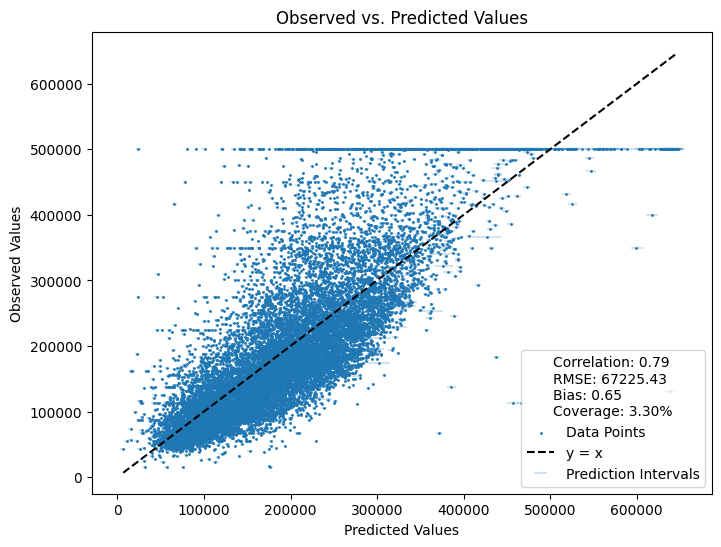

In [11]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(monte_carlo_medians, y, s=1, alpha=1, label='Data Points')
plt.errorbar(
    monte_carlo_medians,
    y,
    xerr=[monte_carlo_medians - prediction_intervals[0, :], prediction_intervals[1, :] - monte_carlo_medians],
    fmt='none',
    alpha=0.2,
    label='Prediction Intervals'
)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

# Add metrics to legend
legend_text = (
    f'Correlation: {correlation:.2f}\n'
    f'RMSE: {rmse:.2f}\n'
    f'Bias: {bias:.2f}\n'
    f'Coverage: {coverage:.2%}'
)
plt.legend(title=legend_text, loc='lower right')

# Labeling
plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')

# Display plot
plt.show()

**Interpret**

**Performance Metrics** :
   - **Correlation (0.78)**: Indicates a strong positive linear relationship between observed and predicted values.
   - **RMSE (67774.08)**: The Root Mean Squared Error quantifies the average prediction error, with smaller values indicating better model performance.
   - **Bias (-24.91)**: Reflects the average difference between observed and predicted values, with negative bias indicating slight underestimation.
   - **Coverage (2.70%)**: Likely relates to the proportion of data points within the prediction intervals, although 2.7% seems low and might require clarification.


- The model generally captures the trend of the data well, as indicated by the correlation and clustering of points near the diagonal line.
- The relatively high RMSE suggests significant variability in prediction accuracy.
- The low coverage percentage implies the prediction intervals are too narrow or not accurately representing the uncertainty in the predictions.

